# An introduction to optimal control using Crocoddyl

The goal of this notebook is to provide an introduction to optimal control and trajectory optimization, to solve two toy problems: a unicycle and an bicopter. At the end it gives an introduction to optimal control with hard cosntraints.

## Setup

In [1]:
import gepetuto.magic

NB: as for all the tutorials, a magic command %do_not_load is introduced to hide
    the solutions to some questions. Change it for %load if you want to see (and
    execute) the solution.


For this version of the introduction, we are going to use Crocoddyl V2.0.
Crocoddyl stands for Contact robot control with differential dynamic programming library. We will need it for formulating and solving the optimal control problems. 

----
## Starting example: the unicycle

![Schema of the unicycle model](tp5/unicycle.png)

An unicycle represents a kinematic model of a car where it's only possible to move in two directions, i.e. it drives forward and turns on the spot. Its dynamics has nonholonomic constraints because it cannot move sideways. Remember that nonholonomic constraints are nonintegral and has the form $\mathbf{f(q,\dot{q})=0}$.

In this example, we define an optimal-control problem for the classical unicycle problem. Our goal is to drive the unicycle towards the origin but at the same time not too fast. For that, the cost function is described as the sum between the distance to the origin and the system speed.

Basically, our optimal control problem has the following simulation model (ie predicting $x_{next}$ from current state $x$ and control $u$) and cost function:

In [2]:
import numpy as np
x = np.random.rand(3)
u = np.random.rand(2)

# Unicycle dynamical model
v,w = u
c,s = np.cos(x[2]),np.sin(x[2])
dt = 1e-2
dx = np.array([ v*c, v*s, w ])
xnext = x + dx*dt

# Cost function: driving to origin (state) and reducing speed (control)
stateWeight = 1
ctrlWeight = 1
costResiduals = np.concatenate([stateWeight*x,ctrlWeight*u])
cost = .5* sum(costResiduals**2)

### Crocoddyl model of the unicycle


For this basic example, the unicycle model is coded in the library. We will just load it and use it. If you are very curious, have a look! It is in https://github.com/loco-3d/crocoddyl/blob/master/include/crocoddyl/core/actions/unicycle.hxx . We will show you below how a similar model can be developped in Python (easier for prototyping, but far less efficient).

We create such a model with the following lines:

In [3]:
import crocoddyl
model = crocoddyl.ActionModelUnicycle()
data  = model.createData()

The action model contains ... well ... the description of the dynamics and cost function. There you find also the action model parameters (here the time step and the cost weights). On the other hand, the data has the buffers where the results of the calculus are stored.

We decided for this separation for an obvious reason that is given just below.

In [4]:
model.costWeights = np.array([
    1,   # state weight
    1  # control weight
])

### Defining the shooting problem

Now we have the action model, let's define the complete problem.
A shooting problem is defined by the initial state from which computing the rollout and a sequence of action models.

In [5]:
# %load tp5/generated/unicycle_toward_origin_hyperparams
### HYPER PARAMS: horizon and initial state
T  = 100
x0 = np.array([-1,-1,1])


In [6]:
problem = crocoddyl.ShootingProblem(x0, [ model ] * T, model)

Here we define a problem starting from $\mathbf{x}_0$ with 20 timesteps (of 0.1 sec by default implementation of unicycle). The terminal action model is defined using the running action model.

This defines the model, not any algorithm to solve it. The only computation that the problem can provide is to integrate the system for a given sequence of controls.

In [7]:
us = [ np.array([1., .1]).T for t in range(T)]
xs = problem.rollout(us)

The plotUnicycle function plots the system as two arrows that represent the wheels

(-3.0, 1.0, -2.0, 2.0)

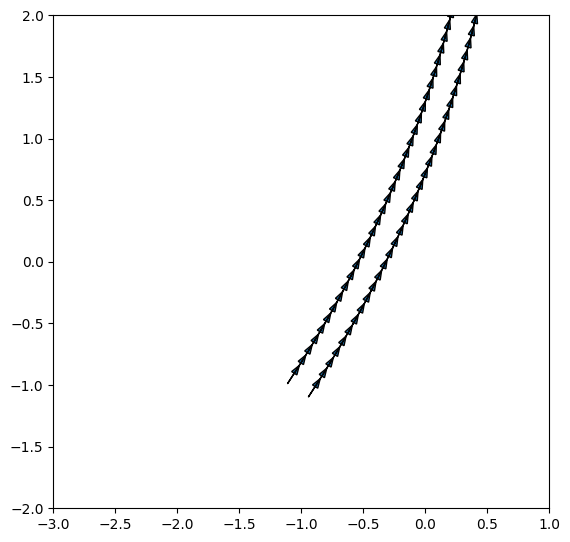

In [8]:
%matplotlib inline
import matplotlib.pylab as plt
from tp5.unicycle_utils import plotUnicycleSolution
plotUnicycleSolution(xs)
plt.axis([-3,1.,-2.,2.])

### Solve the OCP

The main solver is named SolverDDP. Other solvers exist, and you can also add other solvers (taken off the shelf, reimplemented from the literature and invented by yourselves). More on this in the second exercise. 

The DDP solver is initialized with the problem object and mostly contains the ddp.solve method. 

In [9]:
# %load tp5/generated/unicycle_toward_origin_ddp
# Select the solver for this problem
ddp = crocoddyl.SolverDDP(problem)


A useful tool, classical to many solvers, is the callback function, that will be called at every iteration. Here we set up two of them: the first will verbosely comment the solver progress, and the second log the progress for later exploitation in plots.

In [10]:
# %load tp5/generated/unicycle_toward_origin_callback
# Add solvers for verbosity and plots
ddp.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose()])


We can warm start it and tune the parameters, but for the simple unicycle, let's just solve it!

In [11]:
# %load tp5/generated/unicycle_toward_origin_solve
done = ddp.solve()
assert(done)

iter    cost       merit      stop       grad       preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
   0  2.456e+01  0.000e+00  0.000e+00  0.000e+00  1.000e-09  1.000e-09  1.0000  1.000e+00  0.000e+00  0.000e+00  0.000e+00 -2.456e+01  0.000e+00  0.000e+00
   1  1.730e+01  0.000e+00  7.258e+00  1.452e+01  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  7.258e+00  7.265e+00  0.000e+00  0.000e+00
   2  1.724e+01  0.000e+00  5.455e-02  1.091e-01  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  5.455e-02  5.407e-02  0.000e+00  0.000e+00
   3  1.724e+01  0.000e+00  2.502e-03  5.004e-03  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  2.502e-03  2.391e-03  0.000e+00  0.000e+00
   4  1.724e+01  0.000e+00  1.758e-04  3.516e-04  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  1.758e-04  1.623e-04  0.000e+00  0.000e+00
   5  1.724e+01  0.000e+00  1.462e-05  2.923e-05  1.000e-09  1.000e

Let's plot the result

(-0.2, 0.2, -0.2, 0.2)

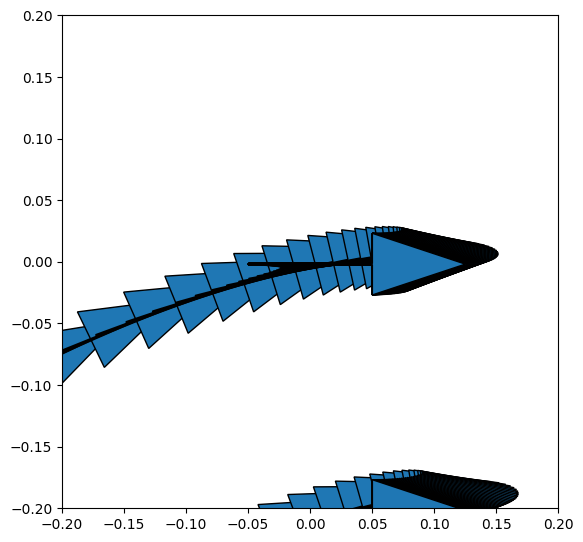

In [12]:
plotUnicycleSolution(ddp.xs)
plt.axis([-0.2,0.2,-0.2,0.2])

The solver journey is typically plotted like this.

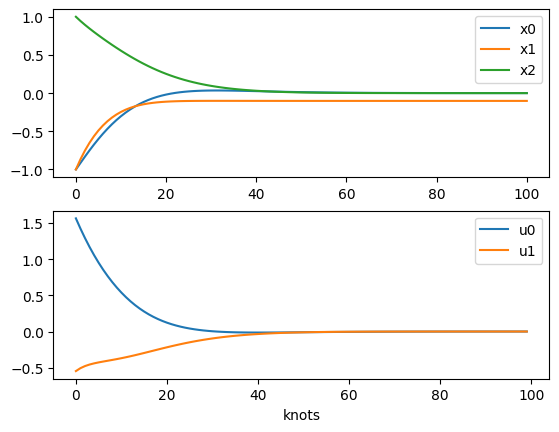

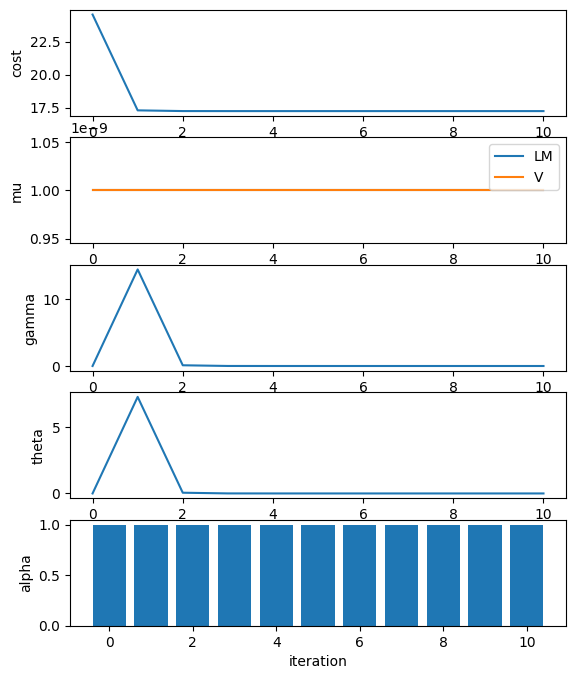

In [13]:
# %load tp5/generated/unicycle_toward_origin_plotlog
log = ddp.getCallbacks()[0]
crocoddyl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
crocoddyl.plotConvergence(
    log.costs,
    log.pregs,
    log.dregs,
    log.grads,
    log.stops,
    log.steps,
    figIndex=2,
    show=False,
)


The terminal state chosen by the solver is:

In [14]:
print(ddp.xs[-1])

[ 2.29114996e-04 -1.01830026e-01  2.06212045e-05]


### Well, the terminal state is not so nicely in the origin.

Question 1: why?

Question 2: How can you change this?

Question 3: by changing the cost parameters, the time horizon and the initial position, can you trigger a maneuver?

iter    cost       merit      stop       grad       preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
   0  5.000e+01  0.000e+00  0.000e+00  0.000e+00  1.000e-09  1.000e-09  1.0000  1.000e+00  0.000e+00  0.000e+00  0.000e+00 -5.000e+01  0.000e+00  0.000e+00
   1  5.000e+01  0.000e+00  0.000e+00  0.000e+00  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
Type plt.show() to display the result.
UnicycleTest


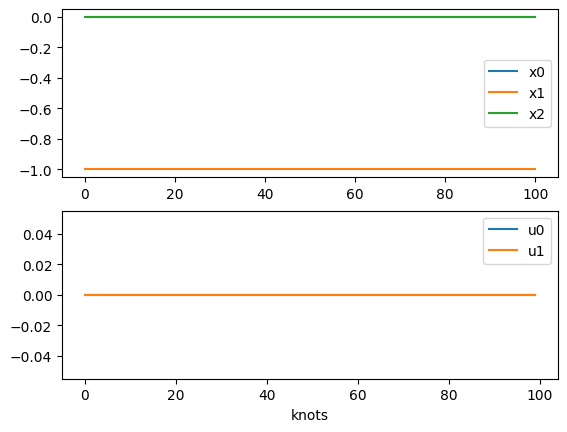

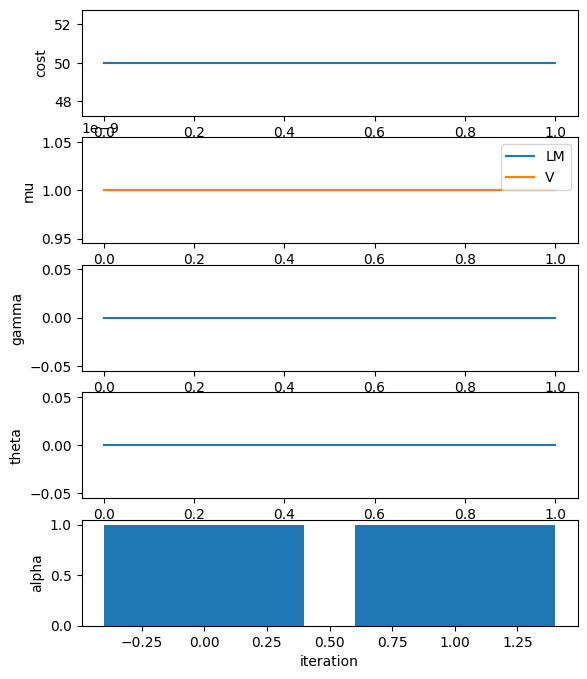

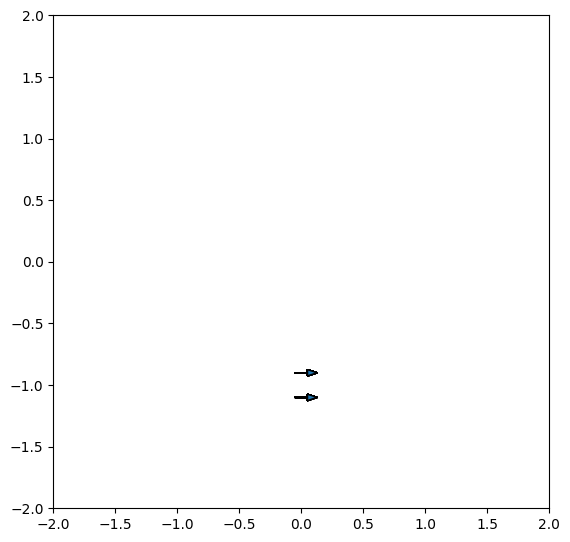

In [15]:
# %load tp5/unicycle_toward_origin.py
import crocoddyl
import numpy as np
import matplotlib.pylab as plt
import unittest
from tp5.unicycle_utils import plotUnicycleSolution

# %jupyter_snippet hyperparams
### HYPER PARAMS: horizon and initial state
T  = 100
x0 = np.array([0,-1,0])
# %end_jupyter_snippet

### PROBLEM DEFINITION

model = crocoddyl.ActionModelUnicycle()
# %jupyter_snippet termmodel
model_term = crocoddyl.ActionModelUnicycle()

model.costWeights = np.array([
    1e-4,   # state weight
    1  # control weight
]).T
model_term.costWeights = np.array([
    10,   # state weight
    0  # control weight
]).T
# %end_jupyter_snippet

# Define the optimal control problem.
problem = crocoddyl.ShootingProblem(x0, [ model ] * T, model_term)
# %jupyter_snippet ddp
# Select the solver for this problem
ddp = crocoddyl.SolverDDP(problem)
# %end_jupyter_snippet

# %jupyter_snippet callback
# Add solvers for verbosity and plots
ddp.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose()])
# %end_jupyter_snippet

### SOLVE THE PROBLEM

# %jupyter_snippet solve
done = ddp.solve()
assert(done)
# %end_jupyter_snippet

### PLOT 

# %jupyter_snippet plotlog
log = ddp.getCallbacks()[0]
crocoddyl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
crocoddyl.plotConvergence(
    log.costs,
    log.pregs,
    log.dregs,
    log.grads,
    log.stops,
    log.steps,
    figIndex=2,
    show=False,
)
# %end_jupyter_snippet

plotUnicycleSolution(log.xs)

print('Type plt.show() to display the result.')

### TEST ZONE ############################################################
### This last part is to automatically validate the versions of this example.
class UnicycleTest(unittest.TestCase):
    def test_logs(self):
        print(self.__class__.__name__)
        self.assertTrue( len(ddp.xs) == len(ddp.us)+1 )
        self.assertTrue( np.allclose(ddp.xs[0],ddp.problem.x0) )
        self.assertTrue( ddp.stop<1e-6 )
        
if __name__ == "__main__":
    UnicycleTest().test_logs()


----
## Defining your own (bicopter) model

Unicycle is a very basic example. Most interesting problems in robotics are written at the acceleration level to easily convey forces and action-reaction phenomena. We will now consider a bicopter model (i.e. a UAV evolving in a vertical plane). It is composed of two rotors producing pure orthogonal forces, hence leading to linear and angular accelerations resulting from the thrust and gravity effects. 

### Bicopter equations of motion

The bicopter is defined by its mass $m$, wingspan $l$ (distance from the copter center to each propeller), inertia $i=l^2m$ and gravity $g$. The state $x=(q,v)$ is the concatenation of position and velocity of the copter, with $q=(x_1,x_2,\theta)$, $x_1$ the horizontal position, $x_2$ the vertical position and $\theta$ the angle) and  $v=(v_1,v_2,\omega)$ the horizontal, vertical and angle velocities.
The control is the thrust (vertical forces) of right then leg propellers $(u=(f_r, f_l)$).

The linear and angular forces due to the propellers are easy to express in the local frame:
$$f = \left(0, f_r+f_l, (f_l-f_r) l \right)$$
The acceleration in world frame is then obtained by rotating the linear forces, dividing by mass and inertia and adding the gravity:
$$a = \left(\frac{f[1] \sin(\theta)}{m}, \frac{f[1] \cos(\theta)}{m}-g, \frac{f[2]}{i} \right)$$

### Integration of the motion equations
Like for the unicyle model, we need to integrate this quantity to get the next state $x_{next}$ from the current state $x$ and control $u$. Now, the bicopter is in acceleration, so the integration should be repeated twice (from acceleration to position). We could do that directly in the action model. Yet Crocoddyl is proposing to split this in two different classes, specifically for acceleration-based models.
- The *differential* action model (DAM) implement the (acceleration) equation of motion and integral cost written as a differential.
- The *integral* action model (IAM) takes the differential and numerically integrates it. We mostly propose to use Euler integration (although RK4 integration is also available, and other integrator can be implemented). The next state $x_+=(q_+,v_+)$ is then obtained from $x=(q,v)$ and the computed acceleration:
$$v_+ = v + a \Delta t$$
$$q_+ = q + v_+ \Delta t$$
with $\Delta t$ the integration step, defined as a hyperparameter (tune it with the trade-off between numerical accuracy --pleading for small $\Delta t$-- and computational efficiency --pleading for large $\Delta t$). Note the $v_+$ in the second row: we call that *implicit* Euler integration, and it is marginally more stable.


In Crocoddyl, we often write the costs as a sum of square. The cost $\ell(x,u)$ is typically defined as:
$$\ell(x,u) = \frac{1}{2} r(x,u)^T r(x,u)$$
with $r(x,u)$ is called the residuals.
This has the practical consequence that we can approximate the Hessian of the cost $H$ can be approximated to the squared of the residual Jacobian, e.g.:
$$\frac{\partial^2 \ell}{\partial x^2} \approx \frac{\partial r}{\partial x}^T \frac{\partial r}{\partial x}$$

For the copter, we propose to put quite a lot of terms in $r$ so that you can *play* with many hyperparameters to tune:
$$r=(x_1,x_2,\sin(\theta),1-\cos(\theta),v,u,a) \in \mathbb{R}^{12}$$

### Hyperparameters

The optimal control will be defined by the following hyperparameters.

In [16]:
# %load tp5/generated/bicopter_toward_origin_hyperparams
### HYPER PARAMS: horizon and initial state
timeStep = 0.01
x0 = np.array([1.0, 0.0, 0.0,  0.0, 0.0, 0.0])
T = 50


### Syntax of the DAM

Below is a template for the DAM. Implement the equation of motion in the *calc* function. It must compute the acceleration and store it in +data.xout+ (array of size 3); the residual and store it in +data.residual+ (array of size 12); and the cost as half of the sum of $r$ squared.

In [17]:
# %load tp5/generated/bicopter_toward_origin_dam_header
class DifferentialActionModelBicopter(crocoddyl.DifferentialActionModelAbstract):

    def __init__(self):
        '''
        Init on top of the DAM class. 
        Mostly set up the hyperparameters of this model (mass, length, cost, etc).
        ng=0 says we have 0 constraints.
        '''
        crocoddyl.DifferentialActionModelAbstract.__init__(
            self, crocoddyl.StateVector(6), nu=2, nr=12, ng=0
        )
        self.unone = np.zeros(self.nu)

        self.span = .2
        self.mass = 2.
        self.g = 10
        self.inertia = self.mass*self.span**2

        self.costWeights = [
            0.1, # x
            0.1, # z
            .10, # s
            .10, # c
            0.001, # vx
            0.001, # vz
            0.001, # w
            0.0, # fr
            0.0, # fl
            0.001,0.001,0.001, # a
        ]  # sin, 1-cos, x, xdot, thdot, f

    def calc(self, data, x, u=None):
        if u is None:
            u = model.unone
        # Getting the state and control variables
        x1,x2,th,v1,v2,w = x
        fr,fl = u

        # Shortname for system parameters
        mass,span,g,inertia=self.mass,self.span,self.g,self.inertia
        s, c = np.sin(th), np.cos(th)

        # Defining the equation of motions
        # Force (fx,fz,tauy) in local frame
        loc_f = np.array([0, fr+fl, (fl-fr)*span])
        # Acceleration (x,z,th) in world frame
        data.xout = np.array([
            -loc_f[1]*s/mass,
            loc_f[1]*c/mass - g,
            loc_f[2]/inertia
        ])

        # Computing the cost residual and value
        data.r = self.costWeights * np.array([x1, x2, s, 1 - c,
                                              v1, v2, w,
                                              fr, fl,
                                              data.xout[0], data.xout[1], data.xout[2] ])
        data.cost = 0.5 * sum(data.r ** 2)



Fill this template by adding your own code. Then create a model object.

In [18]:
# %load tp5/generated/bicopter_toward_origin_dam
# Creating the DAM for the bicopter
dam = DifferentialActionModelBicopter()


### Finite differences

You can also define a +calcDiff+ method, with the same signature of +calc+, to compute the derivatives and store them in the corresponding fields of +data+. This is more advanced, useful for accuracy and efficiency. For today, we are rather going to compute the derivatives by finite differencing.

In [19]:
# %load tp5/generated/bicopter_toward_origin_dam_nd
# Using NumDiff for computing the derivatives. We specify the
# withGaussApprox=True to have approximation of the Hessian based on the
# Jacobian of the cost residuals.
damND = crocoddyl.DifferentialActionModelNumDiff(dam, True)


### Syntax of the integrator

The DAM now just has to be given to a integrator "IAM" model.

In [20]:
# %load tp5/generated/bicopter_toward_origin_iam
# Getting the IAM using the simpletic Euler rule
iam = crocoddyl.IntegratedActionModelEuler(damND, timeStep)


### Terminal model

We suggest you use different weights for the terminal model.

In [21]:
# %load tp5/generated/bicopter_toward_origin_termmodel
# Similarly creates a terminal model, but change the cost weights
terminalDam = DifferentialActionModelBicopter()
terminalDamND = crocoddyl.DifferentialActionModelNumDiff(terminalDam, True)
terminalIam = crocoddyl.IntegratedActionModelEuler(terminalDamND)

terminalDam.costWeights[0] = 100 # horizontal position
terminalDam.costWeights[1] = 100 # vertical position
terminalDam.costWeights[2] = 100.0 # angle sin (first order)
terminalDam.costWeights[3] = 100.0 # angle cos (second order)
terminalDam.costWeights[4] = 100 # horizontal velocity
terminalDam.costWeights[5] = 100 # vertical velocity
terminalDam.costWeights[6] = 100 # angular velocity


### Definition of the optimal control problem

Now, you classically do:

In [22]:
# %load tp5/generated/bicopter_toward_origin_ocp
# Define the optimal control problem.
problem = crocoddyl.ShootingProblem(x0, [iam] * T, terminalIam)

# Solving it using DDP
ddp = crocoddyl.SolverDDP(problem)
ddp.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose()])

### SOLVE THE PROBLEM

done = ddp.solve([], [], 300)
assert(done)


iter    cost       merit      stop       grad       preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
   0  5.000e+03  0.000e+00  5.001e+01  1.000e+02  1.000e-09  1.000e-09  1.0000  1.000e+00  0.000e+00  0.000e+00  5.001e+01 -5.000e+03  0.000e+00  0.000e+00
   1  2.823e+03  0.000e+00  5.000e+03  1.000e+04  1.000e-09  1.000e-09  0.2500  0.000e+00  0.000e+00  0.000e+00  2.187e+03  2.177e+03  0.000e+00  0.000e+00
   2  1.591e+03  0.000e+00  2.823e+03  5.647e+03  1.000e-09  1.000e-09  0.2500  0.000e+00  0.000e+00  0.000e+00  1.235e+03  1.233e+03  0.000e+00  0.000e+00
   3  5.068e+02  0.000e+00  1.591e+03  3.182e+03  1.000e-09  1.000e-09  0.5000  0.000e+00  0.000e+00  0.000e+00  1.193e+03  1.084e+03  0.000e+00  0.000e+00
   4  3.640e+02  0.000e+00  5.068e+02  1.014e+03  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  5.068e+02  1.428e+02  0.000e+00  0.000e+00
   5  3.113e+02  0.000e+00  3.640e+02  7.281e+02  1.000e-09  1.000e

### Visualize the solution
Plot ...

In [23]:
from tp5.bicopter_utils import plotBicopterSolution,ViewerBicopter

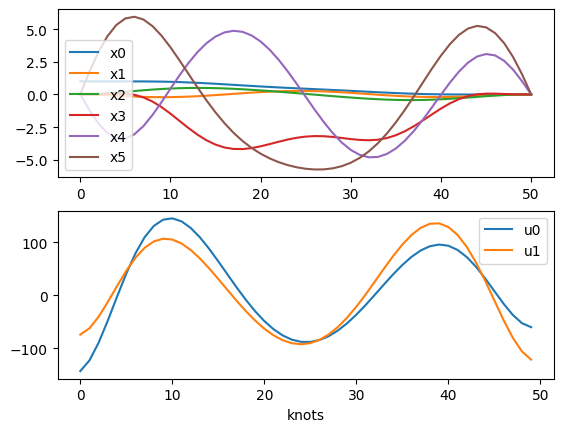

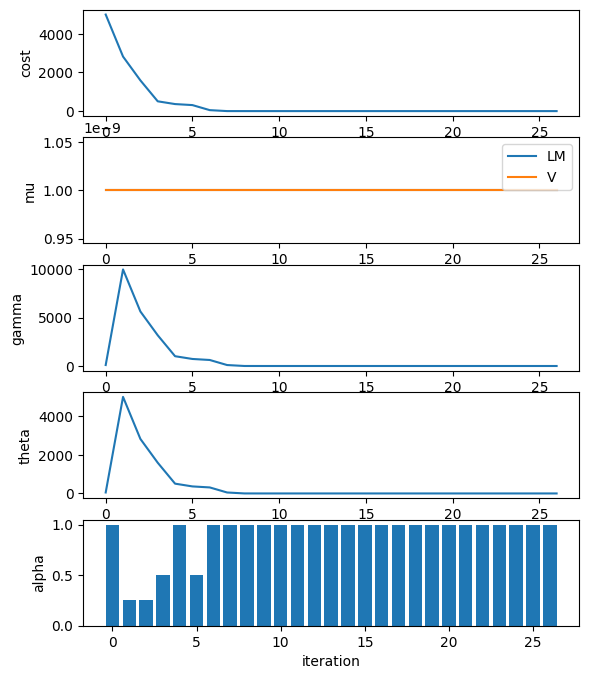

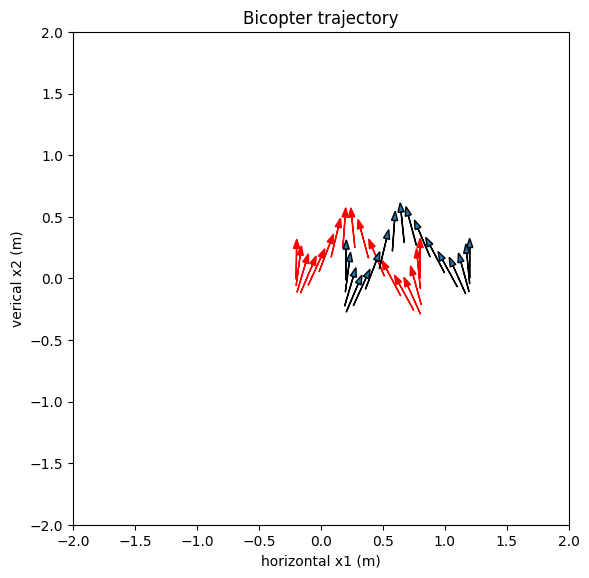

In [24]:
# %load tp5/generated/bicopter_toward_origin_plot
log = ddp.getCallbacks()[0]
crocoddyl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
crocoddyl.plotConvergence(
    log.costs,
    log.pregs,
    log.dregs,
    log.grads,
    log.stops,
    log.steps,
    figIndex=2,
    show=False,
)

plotBicopterSolution(list(ddp.xs)[::3])


If you want, you can see the movement in a 3D visualization. 

In [25]:
viz = ViewerBicopter()
viz.viz.viewer.jupyter_cell()

*** You asked to start meshcat "classically" in tcp://127.0.0.1:6000
*** Did you start meshcat manually (meshcat-server)
Wrapper tries to connect to server <tcp://127.0.0.1:6000>
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [35]:
viz.displayTrajectory(ddp.xs,timeStep*10)

----
## (optional) A first taste of OCP with constraints

### Setup
For this optional part, you will need an additional library call MIM Solvers, available in package [cmeel-mim-solvers](https://pypi.org/project/cmeel-mim-solvers/).

In [27]:
!pip install cmeel-mim-solvers

### Model

The bicopter is a physical system that cannot apply negative propeller forces. 
We can make that explicit with a hard constraint. The DDP solver cannot tackle that, but more advanced solvers can. More on this in the next notebook.

Here we just give a quick introduction about how to add constraints to more advanced solver. Let's take the example of adding the constraints $f_r\ge 0$, $f_l\ge 0$.

This is a very simple introduction to the constraint solver, with very few details, mostly an example. We put it because it is nice to use and logically follows the work on the unconstrained (then unrealistic) bicopter. If you are curious to know more, you need to process the second notebook, then come back here to review the example again. But you should be able to quickly browse this example first.

### Define a DAM with constraints

First, the DAM class must be defined with ng=2.

Then the right-hand terms of the constraints must be evaluated by the +calc+ function and stored in +data.g+ (which is a +np.array+ of size 2).

In [44]:
# %load tp5/generated/bicopter_toward_origin_with_constraints_dam
class DifferentialActionModelBicopter(crocoddyl.DifferentialActionModelAbstract):

    def __init__(self):
        '''
        Init on top of the DAM class. 
        Mostly set up the hyperparameters of this model (mass, length, cost, etc).
        '''
        crocoddyl.DifferentialActionModelAbstract.__init__(
            self, crocoddyl.StateVector(6), nu=2, nr=12, ng=2
        )
        self.unone = np.zeros(self.nu)

        self.span = .2
        self.mass = 2.
        self.g = 10
        self.inertia = self.mass*self.span**2

        self.costWeights = [
            0.1, # x
            0.1, # z
            .10, # s
            .10, # c
            0.001, # vx
            0.001, # vz
            0.001, # w
            0.0, # fr
            0.0, # fl
            0.001,0.001,0.001, # a
        ]  # sin, 1-cos, x, xdot, thdot, f

    def calc(self, data, x, u=None):
        if u is None:
            u = model.unone
        # Getting the state and control variables
        x1,x2,th,v1,v2,w = x
        fr,fl = u

        # Shortname for system parameters
        mass,span,g,inertia=self.mass,self.span,self.g,self.inertia
        s, c = np.sin(th), np.cos(th)

        # Defining the equation of motions
        # Force (fx,fz,tauy) in local frame
        loc_f = np.array([0, fr+fl, (fl-fr)*span])
        # Acceleration (x,z,th) in world frame
        data.xout = np.array([
            -loc_f[1]*s/mass,
            loc_f[1]*c/mass - g,
            loc_f[2]/inertia
        ])

        # Computing the cost residual and value
        data.r = self.costWeights * np.array([x1, x2, s, 1 - c,
                                              v1, v2, w,
                                              fr, fl,
                                              data.xout[0], data.xout[1], data.xout[2] ])
        data.cost = 0.5 * sum(data.r ** 2)

        data.g = np.array([u[0], u[1]])

    def calcDiff(self, data, x, u=None):
        # Advance user might implement the derivatives. Here
        # we will rely on finite differences.
        pass


You can now create a DAM that accepts constraints bounds.

In [45]:
# %load tp5/generated/bicopter_toward_origin_with_constraints_dam_with_bounds
# Creating the DAM for the bicopter with constrains
dam = DifferentialActionModelBicopter()

# Using NumDiff for computing the derivatives. We specify the
# withGaussApprox=True to have approximation of the Hessian based on the
# Jacobian of the cost residuals.
damND = crocoddyl.DifferentialActionModelNumDiff(dam, True)


Finally, the upper and lower bounds (left-hard term in our case) must be set once the DAM object is created. 

In [46]:
damND.g_lb = np.array([0, 0])
damND.g_ub = np.array([20, 20])# %end_jupyter_snippet

That's mostly the only change in the syntax, now the same problem as before can be formulated with forces bounds.

In [47]:
# %load tp5/generated/bicopter_toward_origin_with_constraints_problem
# Getting the IAM using the simpletic Euler rule
iam = crocoddyl.IntegratedActionModelEuler(damND, timeStep)

# Similarly creates a terminal model, but change the cost weights
terminalDam = DifferentialActionModelBicopter()
terminalDamND = crocoddyl.DifferentialActionModelNumDiff(terminalDam, True)
terminalIam = crocoddyl.IntegratedActionModelEuler(terminalDamND)

terminalDam.costWeights[0] = 100 # horizontal position
terminalDam.costWeights[1] = 100 # vertical position
terminalDam.costWeights[2] = 100.0 # angle sin (first order)
terminalDam.costWeights[3] = 100.0 # angle cos (second order)
terminalDam.costWeights[4] = 100 # horizontal velocity
terminalDam.costWeights[5] = 100 # vertical velocity
terminalDam.costWeights[6] = 100 # angular velocity


### Define a solver that accepts constraints
DDP will just skip your constraints, unnoticed. We will use here the MIM SQP solver.
First import the MIM solver package.

In [48]:
import mim_solvers

This is an example of configuration of this solver.

In [57]:
T=300

In [58]:
# %load tp5/generated/bicopter_toward_origin_with_constraints_ocp
# Define the optimal control problem.
problem = crocoddyl.ShootingProblem(x0, [iam] * T, terminalIam)

# Solving it using DDP
csolver = mim_solvers.SolverCSQP(problem)
MAX_ITER = 300
csolver.termination_tolerance = 1e-4
csolver.with_callbacks = True
csolver.use_filter_line_search = True
csolver.filter_size = MAX_ITER
csolver.eps_abs = 1e-5
csolver.eps_rel = 0.0
csolver.max_qp_iters = 10000
    
### SOLVE THE PROBLEM
done = csolver.solve([x0]*(T+1), [np.zeros(2)]*T, MAX_ITER)
assert(done)


iter     merit        cost         grad       step     ||gaps||       KKT       Constraint Norms    QP Iters
   0  5.30302e+03  5.00002e+03  2.00000e+01  1.0000  3.03000e+01  1.00000e+04    0.00000e+00         27
   1  5.00002e+03  5.00002e+03  3.25999e+00  1.0000  2.39222e-06  3.00000e+03    0.00000e+00         106
   2  4.24998e+00  3.01183e-03  5.09642e+00  1.0000  4.24697e-01  1.13091e-02    3.29692e-07         1849
   3  4.68095e+00  2.66182e-03  1.78880e+00  1.0000  4.67829e-01  1.46431e-02    1.76162e-07         1871
   4  1.36321e+00  2.71348e-03  1.16874e+00  1.0000  1.36050e-01  5.80440e-03    3.56124e-09         1835
   5  2.77964e-01  2.73506e-03  5.30622e-01  1.0000  2.75229e-02  6.84169e-04    1.47056e-08         1855
   6  6.79951e-02  2.73695e-03  3.16501e-01  1.0000  6.52580e-03  3.21214e-04    8.03563e-09         1852


In [59]:
problem.runningDatas[0].g, csolver.us[0]

(array([3.36775998e-08, 2.00000000e+01]),
 array([3.36775998e-08, 2.00000000e+01]))

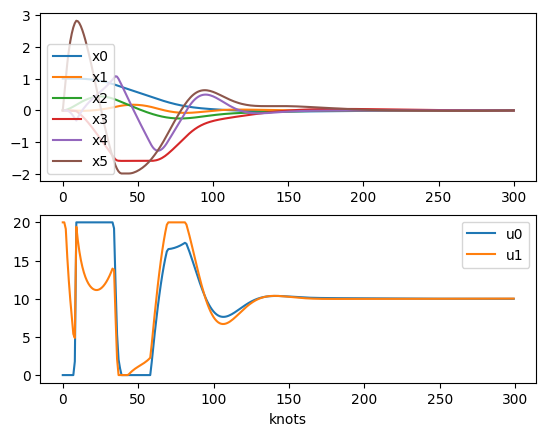

<Figure size 640x480 with 0 Axes>

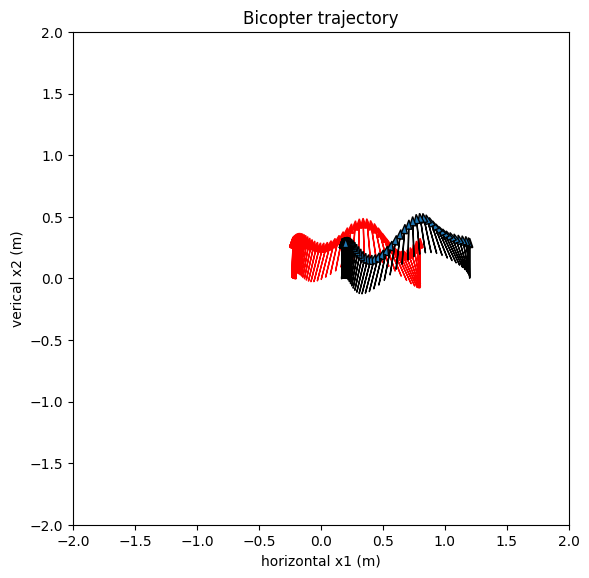

In [60]:
crocoddyl.plotOCSolution(csolver.xs, csolver.us, figIndex=1, show=False)
plt.figure()
plotBicopterSolution(list(csolver.xs)[::3])


----
## Conclusion

Like the unicycle, you can similarly play with the copter, changing the initial conditions or the weights, which should trigger different maneuvers or even strange behaviors. Remember this is a local optimization solver, which you better warm start with a sound behavior when trying to achieve something fancy.

In this work, you drove you to use the basic part of Crocoddyl API: the basic solver DDP, and the basic front end. For the front end, many features based on Pinocchio are implemented. For the solvers, other more advanced solvers have been added, and we hope many more are to come. We will introduce you to these more advanced features in the next practicals, featuring a manipulator robot.